# ENSF 544 Data Science for Software Engineers
## Project 2 Phase 1
#### By: Kyle Friedt, Erslan Salman, Avneet Gill, and Kelvin Tran 

# Phase 1 

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re

### Now load the pickle data into dataframes from the Output folder one directory above

In [2]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()

display(all_projects_source_codes.head())
display(all_projects_bugreports.head())

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS


,fix,text,fixdate,summary,description,project,average_precision
id,,,,,,,
217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0


# Preprocessing
#### This section contains all the file for cleaning up the source files and bug reports

The main steps we took are:
- removing and cleaning up new lines or extra lines in the unprocessed code
- changing source file paths and bug fix file paths to be of the same format for comparison later 
- cleaning composite words that have a `camelCase` syntax 
- removing english stop words, java key words and java operators
- stemming & tokenizing 
- combing description and summary for bug report to create the query

#### Removing new lines

In [3]:


#remove next line characters:
def remove_new_lines(text):
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

#### Cleaning file paths

In [4]:
# changes file path to be just the filename + extension for source code files
def clean_sc_file(x):
    file = x.split("\\")
    return ''.join(file[-1:])

# changes file path to be just the filename + extension for bug report fixes 
def clean_bug_file(x):
    fixes = []

    for file in x:
        file = file.split(".")
        file = '.'.join(file[-2:])
        fixes.append(file)
    return fixes


def clean_sc_filepath(df):
    df.filename = df.filename.map(clean_sc_file)
    return df


def clean_bug_filepath(df):
    df['fix'] = df['fix'].map(clean_bug_file)
    return df

#### Cleaning composite words

In [5]:
#splitting composite words
#splits using camlecase syntax
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


#### Removing fixes that can't be found

In [6]:
# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
        fix_sub=list()
        for fix in fixes:
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
        fix_list.append(fix_sub)
    # this is a list of the indexes of the file where the fix was located
    return fix_list

In [7]:
def removeFixesNotFound(bug, src):
    bug["fix_indexes"] = get_fix_indexes(bug, src)
    fixes = bug.fix.tolist()
    fix_indexes = bug.fix_indexes.tolist()
    fixes_return = []
    fixes_indexes_return = []
    numFixes = []
    for i in range(len(fixes)):
        fixes_temp = []
        indexes_temp = []
        numFixes.append(len(fix_indexes[i]))
        for l in range(len(fix_indexes[i])):
            if fix_indexes[i][l] != -1:           
                fixes_temp.append(fixes[i][l])
                indexes_temp.append(fix_indexes[i][l])
        if len(fixes_temp) == 0:
            fixes_return.append(np.nan)
            fixes_indexes_return.append(np.nan)
        else:
            fixes_return.append(fixes_temp)
            fixes_indexes_return.append(indexes_temp)
        
#         print(fixes_return)
#         print(fixes_indexes_return)
    bug['numFixes'] = numFixes
    bug['fix'] = fixes_return
    bug['fix_indexes'] = fixes_indexes_return 
    
    return bug

#### Combining stop words, keywords and operators

In [8]:


# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
#contains english stop words, java keywords and java operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)



#### Stemming & calling cleaning functions

In [9]:
# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# clean up the unprocessed code column
def clean_source_df(df):
    # clean up the new lines
    df = clean_new_lines_source_code(df)
    # clean up composite words
    df = clean_composite_source_code(df)
    # clean filepaths
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    # clean up new lines
    df = clean_new_lines_bug_report(df)
    # clean composite words
    df = clean_composite_bug_report(df)
    # clean file path
    df = clean_bug_filepath(df)
    # combine summary and descriptions to create query
    df["query"] = df["summary"] + df["description"]
    return df



In [10]:
# drop nan first

all_projects_bugreports = all_projects_bugreports.dropna(axis=0, subset=['fix'], how='all')

#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# remove fixes that aren't found
br_df = removeFixesNotFound(br_df, sc_df)
br_df = br_df.dropna(axis=0, subset=['fix','fix_indexes'], how='all')


# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)



In [11]:
br_df

,fix,text,fixdate,summary,description,project,average_precision,query,fix_indexes,numFixes
id,,,,,,,,,,
217,"[flat3map.java, testflat3map.java]",NaN,2006-07-18 22:02:11,Flat3 Map. Entry.set Value() overwrites other ...,Flat3 Map&amp;apos;s Entry objects will overw...,COLLECTIONS,0.0,Flat3 Map. Entry.set Value() overwrites other ...,"[233, 436]",2
214,"[testextendedproperties.java, extendedproperti...",NaN,2006-07-18 22:44:33,Extended Properties - field include should be ...,"The field ""include"" in Extended Properties is...",COLLECTIONS,0.0,Extended Properties - field include should be ...,"[292, 22]",2
222,"[testlistutils.java, testcollectionutils.java,...",NaN,2006-08-18 19:01:22,Collection Utils remove All is actually retain...,"The remove All( Collection collection, Collec...",COLLECTIONS,0.0,Collection Utils remove All is actually retain...,"[303, 288, 15]",3
261,"[flat3map.java, testflat3map.java]",NaN,2007-08-20 14:11:54,Flat3 Map.remove() does not return the correct...,Flat3 Map m = new Flat3 Map();n m.put( new I...,COLLECTIONS,0.0,Flat3 Map.remove() does not return the correct...,"[233, 436]",2
264,[fasttreemap.java],NaN,2007-08-31 09:39:59,Fast Tree Map forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0,Fast Tree Map forgets the comparatorIn line 35...,[27],1
...,...,...,...,...,...,...,...,...,...,...
395,[ciphersuiteselector.java],NaN,2016-06-01 13:52:37,Undertow H T T P S listener offers no cipher ...,No cipher suites are available for handshake w...,ELY,0.0,Undertow H T T P S listener offers no cipher ...,[40],1
614,[abstractpermission.java],NaN,2016-07-29 15:23:39,Missing null check in equals() method of Abst...,There is missing null check in org.wildfly.sec...,ELY,0.0,Missing null check in equals() method of Abst...,[11],1
634,[elytronmessages.java],NaN,2016-10-12 10:32:51,No log messages comming from Elytron - group ...,Elytron is missing any log messages related to...,ELY,0.0,No log messages comming from Elytron - group ...,[64],7


# TF-IDF
### This section contains all the code for applying two different cosine similarity functions

In this sections we apply two different similarity functions, equation (1) and equations(7) from the report. 
The TF-IDF is fitted to each of the 12 projects and used to calculate the similarity.


For equation (1):
- we used a classic VSM, and found the relevancy score between a file f and a query q as being the cosine similarity between their corresponding vector representations 

For equation (7):
- we used a rVSM, where the relevancy score is calculated between each source code file and the bug report (direct relevancy)
- this is favourable to the classic VSM model as it takes into account the length of files, and does not favour shorter files like equation 1
- we used the file lengths as the number for terms in equations 5


In [12]:
# generate number of terms based off of length of file 
def generate_number_terms(arr):
    f = lambda x: 1 / (1 + np.exp(-1 * x))
    result = f(arr)
    return result

# min max scaler 
def custom_min_max(arr):
    min_val = np.amin(arr)
    max_val = np.amax(arr)
    f = lambda x: (x - min_val) / (max_val - min_val)
    result = f(arr)
        
    return result

# calculate the similarity when using revised Vector Space Model
def calculate_rVSM_similarity(vect, src_vect, query_data, num_terms):
    query = vect.transform(query_data)
    cosSim = cosine_similarity(query, src_vect).flatten()
#     result = np.multiply(cosSim, num_terms)
#     return result

    for i in range(len(cosSim)):
        cosSim[i] = cosSim[i] * num_terms[i]
    return cosSim

# calculate the similarity when using basic cosine similarity   
def calculate_similarity(src_vect, query):    
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim


# generates direct and indirect scores
def generate_scores_list(source, query):
    direct_scores = []
    indirect_scores = []
    # create hash lookup table to decrease search time for filename index.
    lookup_table = dict()
    names = source.filename.tolist()
    for i in range(len(names)):
        lookup_table[names[i]] = i
        
     # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)
    
       
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
    
    # used to define the number of terms for each source code file
    source_lengths = source['unprocessed_code'].map(lambda x: len(x.split()))
#     ****************************************************************************
#     source_lengths = []
#     for src in source['unprocessed_code']:
#         source_lengths.append(len(src.split()))
        
     # normalized length used to calculated normalized num of terms
    normalized_source_length = custom_min_max(source_lengths)

    
    # normalized num of terms
    num_terms = generate_number_terms(normalized_source_length)

    # get the DIRECT and INDIRECT similarity scores for the bug reports
    src_code_len = len(source['unprocessed_code'])
    prev_bugs = query["fix"].tolist()
    num_fixes = query["numFixes"].tolist()
    for q in query["query"]:
        # calculate direct similarity and append it to the list
        similarity = calculate_rVSM_similarity(vect, src_vect, [q], num_terms)
        direct_scores.append(similarity)   
        
        # calculate indirect similarity and append it to the list
        
        indirect_similarity = calculate_indirect_scores(vect, src_code_len, [q], 
                                                        query, prev_bugs, num_fixes, lookup_table)
        indirect_scores.append(indirect_similarity)

#     print(len(direct_scores))
#     print(len(indirect_scores))
    return direct_scores, indirect_scores



# caclulate the similarity between new bugs and old bugs.
def calculate_indirect_scores(vect, src_len, query_data, query_df, prev_bugs, num_fixes, table):
    missing_count = 0
    query = vect.transform(query_data)
    
    # np array of zeros, update the values as needed.
    sim_scores = np.zeros(src_len)

    bug_vect = vect.transform(query_df["query"])
    
    # CAN'T COMPARE A BUG TO IT'S SELF
    # get similarity between the query and the prev bug query
    bugs_sim = calculate_similarity(bug_vect, query) # one of the entries should be 1
    
    num_bugs = len(prev_bugs)
#     print(num_bugs)
#     print(len(bugs_sim))
    for indx in range(num_bugs):
        
#         print("Index: ", indx)

    # get the number of fixes, used for calculating similarity
        num_fix = num_fixes[indx]
    
        # for each fix find it's index in the source['filename'] column
        for fix_indx in range(num_fix):
#             print("Num_fix: ",num_fix)
#             print("fix index: ", fix_indx)
#             print("Previous Bugs at indx:" , prev_bugs[indx])
#             print("Single bug? " ,prev_bugs[indx][fix_indx] )
            if(fix_indx >= len(prev_bugs[indx])):
               continue
            sim_indx = table.get(prev_bugs[indx][fix_indx])
            if(sim_indx):
                if(bugs_sim[indx] == 1):
                    # don't add the similarity values if they are for the same bug
                    pass
                else:
                    sim_scores[sim_indx] = sim_scores[sim_indx] + (bugs_sim[indx]/num_fix)
            else:
                missing_count += 1
    # now we have a list of indirect similarity scores for a single bug and all src code files
#     print("Number missing: ", missing_count)
    return sim_scores



# Phase 2
### Implementing Equation 8
- Layer 1: A single bug report
- Layer 2: All the previous bug reports and their similarity to bug in layer 1 just cosSim (no rVSM)
- Layer 3: The source code files where the bug fixes from bugs in layer 2 are located

### SimiScore
- Similarity between a bug and the files that similar bugs are connected to
- n = the number of fixes for the sovled bug report
- Similarity = cosSim between bug query and solved bug
- SimiScore = sum of all Solved bug reports (Similarity/n) that connect to that file

### Final Score (eq9)
- (1-alpha) x N(rVSMScore) + (alpha) x N(Simi Score)

## Ranking similarities and getting fix indexes to compare 

In this section we rank the files and determine whether the fix was found or not and if it was, which index it was. 

In [13]:
# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()
    
    for score in scores:
        indicies = range(len(score))

        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)

        sim_scores.append(sorted_tuple)
    
    return sim_scores

# MAP, MRR and Other Scores

### This section contains all the code for calculated MAP and MRR, as well scores such as top 1%, 5% and 10%

Calculating MAP:
- To calculate the mean average precision we calculcated equation (11) from the paper and found the mean

Calculating MRR:
- To calculate the mean reciprocal rank we calculated equation (10) form the paper

In [37]:
#Checks the average precision for each bug
def average_precision(fix_indexes,ranked_sim):
    ap_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        hit_list = list()
        countTrue=0
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                countTrue+=1
                hit_list.append(countTrue/(i+1))
        if(countTrue != 0):
            ap_list.append(sum(hit_list)/countTrue)
        else:
            ap_list.append(0)
    return ap_list


#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
def reciprocal_rank(fix_indexes,ranked_sim):
    rr_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        rr = 0
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list

# Gets a list containing the rank of all fixes that were found in the ranked similarity list
def get_fix_rank(fix_indexes, ranked_sim):
    fix_list = list()
    for fixes,ranked_list in zip(fix_indexes,ranked_sim):
        hit_list = list()
        for i in range(len(ranked_list)):
            # check if source file is actually where bug is located
            if(ranked_list[i][1] in fixes):
                hit_list.append(i+1)
        fix_list.append(hit_list)
    return fix_list

### Get metrics into the data frames

In [15]:
# take in the source code df for a project and a single query return scores
import warnings
warnings.filterwarnings("ignore")

def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    i = 0
    for proj in projects:
        print("Getting scores for project ",proj,"...")
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the direct and indirect scores
        direct_scores, indirect_scores = generate_scores_list(src_df, bug_df)
        
        #append direct scores list to the bug dataframe
        bug_df["direct_sim"] = direct_scores # the only way that the matrix is related to the src code 
                                        # is through the index.
            
        #append indirect scores list to bug dataframe
        bug_df["indirect_sim"] = indirect_scores
        
        
        bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)

        
      
        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [16]:
bugs, sources = generate_all_scores()


Getting scores for project  COLLECTIONS ...
Getting scores for project  CONFIGURATION ...
Getting scores for project  IO ...
Getting scores for project  LANG ...
Getting scores for project  DATACMNS ...
Getting scores for project  DATAMONGO ...
Getting scores for project  DATAREST ...
Getting scores for project  LDAP ...
Getting scores for project  SEC ...
Getting scores for project  SOCIALFB ...
Getting scores for project  SPR ...
Getting scores for project  ELY ...


In [17]:
# # Now we generate the final scores, MAP and MRR for all the projects
# def generate_project_metrics():
        
#     all_bugs = []
#     all_src = []
#     for proj in projects: 
    
#         src_df = sources_grouped_df.get_group(proj)
#         bug_df = bugs_grouped_df.get_group(proj).copy()
    
    
#     # #*********************************************************************************************************        
# #         # NEED TO CALCULATE THE FINAL SCORE(ADD DIRECT AND INDRECT)
        
# #         # NEED TO RANK THE DIRECT SCORES AND THE FINAL SCORES
        
# #         # Rank the source code files and know what file(s) the bug was in
# #         bug_df["ranked_sim"] = rank_sim_scores(scores)
# # #*********************************************************************************************************
          
# #         # get list of where the fixes rank
# #         bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)
        
        
# #         # Calculate the AP and RR for Cosine Similarity here
# #         bug_df["average_precision"] = average_precision(bug_df,True)

# #         bug_df["reciprocal_rank"] = reciprocal_rank(bug_df,True)

# #         bug_df["fix_ranks"] = get_fix_rank(bug_df,True)

#         all_bugs.append(bug_df)
#         all_src.append(src_df)
        
#     # concatenate all the data frames in order    
#     all_bug_df = pd.concat(all_bugs, ignore_index=True)
#     all_src_df = pd.concat(all_src, ignore_index=True)
#     return all_bug_df, all_src_df



In [18]:
# bugs.loc[(bugs['project'] == 'COLLECTIONS')]
# bugs df should have the direct_sim,indirect_sim, and fix_indexes at this point
# This is a seperate function because this is going to need to be repeated with many different alpha values
# and the generate_all_scores method would take like 20 mins to run if I added this in there
def generate_weighted_vectors(alpha,bugs):
    norm_direct = bugs['direct_sim'].apply(custom_min_max)
    norm_indirect = bugs['indirect_sim'].apply(custom_min_max)
    weighted_scores = ((norm_direct.apply(lambda x:np.array(x)*(1-alpha))).add(norm_indirect.apply(lambda x:np.array(x)*(alpha))))
    return weighted_scores


def generate_all_weighted_vectors(bugs):
    df = pd.DataFrame()
    df['fix_indexes'] = bugs['fix_indexes']
    df['project'] = bugs['project']
    for x in range(0, 10):
        df['0.'+str(x)] = generate_weighted_vectors(x/10,bugs)
    df['1.0'] = generate_weighted_vectors(1,bugs)
    return df
# weighted_sim_vectors = generate_all_weighted_vectors()
# # display(bugs.loc[(bugs['project'] == 'COLLECTIONS')])
# weighted_sim_vectors

def generate_all_weighted_ranked_vectors(weighted_sim_vectors):
    for x in range(0, 10):
        weighted_sim_vectors['0.'+str(x)+'_ranked'] = rank_sim_scores(weighted_sim_vectors['0.'+str(x)])
    weighted_sim_vectors['1.0_ranked'] = rank_sim_scores(weighted_sim_vectors['1.0'])
    return weighted_sim_vectors
    
weighted_sim_vectors = generate_all_weighted_vectors(bugs)
# display(bugs.loc[(bugs['project'] == 'COLLECTIONS')])
weighted_ranked_df = generate_all_weighted_ranked_vectors(weighted_sim_vectors)
weighted_ranked_df

# Note that some weighted averages are 1.0. This is because the scores were scaled with the min max scaler,
# and both the indirect and direct scores agree on the top result.

,fix_indexes,project,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,...,0.1_ranked,0.2_ranked,0.3_ranked,0.4_ranked,0.5_ranked,0.6_ranked,0.7_ranked,0.8_ranked,0.9_ranked,1.0_ranked
0,"[233, 436]",COLLECTIONS,"[0.10919111728601784, 0.17106634185421943, 0.0...","[0.09827200555741605, 0.1539597076687975, 0.00...","[0.08735289382881428, 0.13685307348337555, 0.0...","[0.07643378210021248, 0.11974643929795359, 0.0...","[0.0655146703716107, 0.10263980511253165, 0.00...","[0.05459555864300892, 0.08553317092710971, 0.0...","[0.04367644691440714, 0.06842653674168778, 0.0...","[0.032757335185805356, 0.05131990255626583, 0....",...,"[(1.0, 233), (0.8867703122292825, 221), (0.806...","[(1.0, 233), (0.7893463906025917, 221), (0.749...","[(1.0, 233), (0.7229881240478103, 223), (0.691...","[(1.0, 233), (0.6967281047448155, 223), (0.689...","[(1.0, 233), (0.6966215172765184, 36), (0.6889...","[(1.0, 233), (0.7075520217907788, 436), (0.703...","[(1.0, 233), (0.7261409438118407, 436), (0.710...","[(1.0, 233), (0.7447298658329027, 436), (0.717...","[(1.0, 233), (0.7633187878539646, 436), (0.724...","[(1.0, 233), (0.7819077098750264, 436), (0.731..."
1,"[292, 22]",COLLECTIONS,"[0.11410394114515082, 0.2458129138963349, 0.08...","[0.10269354703063574, 0.2212316225067014, 0.07...","[0.09128315291612066, 0.19665033111706792, 0.0...","[0.07987275880160558, 0.17206903972743443, 0.0...","[0.0684623646870905, 0.14748774833780093, 0.05...","[0.05705197057257541, 0.12290645694816744, 0.0...","[0.04564157645806033, 0.09832516555853396, 0.0...","[0.034231182343545254, 0.07374387416890048, 0....",...,"[(0.9278513338675408, 22), (0.9, 3), (0.635679...","[(0.8752171140490093, 22), (0.8, 3), (0.565048...","[(0.8225828942304778, 22), (0.7, 3), (0.494417...","[(0.7699486744119463, 22), (0.6, 3), (0.509491...","[(0.7173144545934147, 22), (0.5912429528706415...","[(0.6729943622965132, 36), (0.6646802347748832...","[(0.7547457717223849, 36), (0.6120460149563517...","[(0.8364971811482567, 36), (0.5594117951378201...","[(0.9182485905741283, 36), (0.5067775753192886...","[(1.0, 36), (0.4541433555007571, 292), (0.4541..."
2,"[303, 288, 15]",COLLECTIONS,"[0.09984273938629186, 0.3451281303620781, 0.01...","[0.08985846544766267, 0.31061531732587033, 0.0...","[0.0798741915090335, 0.2761025042896625, 0.009...","[0.0698899175704043, 0.24158969125345467, 0.00...","[0.05990564363177511, 0.20707687821724688, 0.0...","[0.04992136969314593, 0.17256406518103906, 0.0...","[0.03993709575451675, 0.13805125214483124, 0.0...","[0.029952821815887563, 0.10353843910862345, 0....",...,"[(0.9720261638585714, 288), (0.816988320509942...","[(0.944052327717143, 288), (0.7691981305967042...","[(0.9160784915757143, 288), (0.798048364272116...","[(0.8881046554342857, 288), (0.826898597947528...","[(0.8601308192928572, 288), (0.855748831622940...","[(0.8845990652983521, 15), (0.8321569831514286...","[(0.913449298973764, 15), (0.8041831470100002,...","[(0.9422995326491761, 15), (0.7762093108685716...","[(0.971149766324588, 15), (0.7579816859912247,...","[(1.0, 15), (0.7692708046983205, 303), (0.7202..."
3,"[233, 436]",COLLECTIONS,"[0.053924938738897824, 0.06742472991702268, 0....","[0.048532444865008045, 0.060682256925320414, 4...","[0.04313995099111826, 0.053939783933618146, 8....","[0.037747457117228475, 0.04719731094191588, 0....","[0.03235496324333869, 0.04045483795021361, 0.0...","[0.026962469369448912, 0.03371236495851134, 0....","[0.02156997549555913, 0.026969891966809073, 0....","[0.01617748162166935, 0.02022741897510681, 0.0...",...,"[(0.9, 305), (0.7159926268641039, 436), (0.598...","[(0.8, 305), (0.6493970456478302, 436), (0.643...","[(0.7, 305), (0.6879798681258665, 36), (0.5828...","[(0.7325541726793142, 36), (0.6, 305), (0.5162...","[(0.7771284772327618, 36), (0.5, 305), (0.4496...","[(0.8217027817862095, 36), (0.4, 305), (0.3834...","[(0.866277086339657, 36), (0.4069918462359563,...","[(0.9108513908931047, 36), (0.4428276129861087...","[(0.9554256954465524, 36), (0.478663379736261,...","[(1.0, 36), (

In [19]:
### Adding Map and MRR to weighted_ranked_df

def score_results(df):
    for x in range(0, 10):
        df['0.'+str(x)+'_rr'] = reciprocal_rank(df['fix_indexes'],df['0.' + str(x) + '_ranked'])
        df['0.'+str(x)+'_ap'] = average_precision(df['fix_indexes'],df['0.' + str(x) + '_ranked'])
    df['1.0_rr'] = reciprocal_rank(df['fix_indexes'],df['1.0_ranked'])
    df['1.0_ap'] = average_precision(df['fix_indexes'],df['1.0_ranked'])
    
    return df

rr_ap_scores = score_results(weighted_ranked_df)
rr_ap_scores

,fix_indexes,project,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,...,0.6_rr,0.6_ap,0.7_rr,0.7_ap,0.8_rr,0.8_ap,0.9_rr,0.9_ap,1.0_rr,1.0_ap
0,"[233, 436]",COLLECTIONS,"[0.10919111728601784, 0.17106634185421943, 0.0...","[0.09827200555741605, 0.1539597076687975, 0.00...","[0.08735289382881428, 0.13685307348337555, 0.0...","[0.07643378210021248, 0.11974643929795359, 0.0...","[0.0655146703716107, 0.10263980511253165, 0.00...","[0.05459555864300892, 0.08553317092710971, 0.0...","[0.04367644691440714, 0.06842653674168778, 0.0...","[0.032757335185805356, 0.05131990255626583, 0....",...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,"[292, 22]",COLLECTIONS,"[0.11410394114515082, 0.2458129138963349, 0.08...","[0.10269354703063574, 0.2212316225067014, 0.07...","[0.09128315291612066, 0.19665033111706792, 0.0...","[0.07987275880160558, 0.17206903972743443, 0.0...","[0.0684623646870905, 0.14748774833780093, 0.05...","[0.05705197057257541, 0.12290645694816744, 0.0...","[0.04564157645806033, 0.09832516555853396, 0.0...","[0.034231182343545254, 0.07374387416890048, 0....",...,0.500000,0.500000,0.500000,0.583333,0.500000,0.583333,0.500000,0.583333,0.500000,0.583333
2,"[303, 288, 15]",COLLECTIONS,"[0.09984273938629186, 0.3451281303620781, 0.01...","[0.08985846544766267, 0.31061531732587033, 0.0...","[0.0798741915090335, 0.2761025042896625, 0.009...","[0.0698899175704043, 0.24158969125345467, 0.00...","[0.05990564363177511, 0.20707687821724688, 0.0...","[0.04992136969314593, 0.17256406518103906, 0.0...","[0.03993709575451675, 0.13805125214483124, 0.0...","[0.029952821815887563, 0.10353843910862345, 0....",...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,"[233, 436]",COLLECTIONS,"[0.053924938738897824, 0.06742472991702268, 0....","[0.048532444865008045, 0.060682256925320414, 4...","[0.04313995099111826, 0.053939783933618146, 8....","[0.037747457117228475, 0.04719731094191588, 0....","[0.03235496324333869, 0.04045483795021361, 0.0...","[0.026962469369448912, 0.03371236495851134, 0....","[0.02156997549555913, 0.026969891966809073, 0....","[0.01617748162166935, 0.02022741897510681, 0.0...",...,0.333333,0.416667,0.333333,0.416667,0.333333,0.333333,0.333333,0.266667,0.333333,0.233333
4,[27],COLLECTIONS,"[0.023421920771382554, 0.02413902811733814, 0....","[0.0210797286942443, 0.021725125305604324, 0.0...","[0.018737536617106042, 0.019311222493870513, 0...","[0.01639534453996779, 0.016897319682136695, 0....","[0.014053152462829533, 0.014483416870402882, 0...","[0.011710960385691277, 0.01206951405866907, 0....","[0.009368768308553021, 0.009655611246935257, 0...","[0.007026576231414767, 0.007241708435201443, 0...",...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,[40],ELY,"[0.010323501852812996, 0.009039989381700803, 0...","[0.009291151667531698, 0.008135990443530723, 0...","[0.008258801482250397, 0.007231991505360642, 0...","[0.007226451296969097, 0.006327992567190562, 0...","[0.0061941011116877975, 0.005423993629020482, ...","[0.005161750926406498, 0.0045199946908504015, ...","[0.004129400741125199, 0.003615995752680321, 0...","[0.003097050555843899, 0.0027119968145102413, ...",...,0.500000,0.500000,0.333333,0.333333,0.200000,0.200000,0.200000,0.200000,0.033333,0.033333
1680,[-1],ELY,"[0.20151628703988794, 0.09704514903507919, 0.0...","[0.18136465833589915, 0.08734063413157127, 0.0...","[0.16121302963191037, 0.07763611922806335, 0.0...","[0.14106140092792155, 0.06793160432455543, 0.0...","[0.12090977222393276, 0.05822708942104751, 0.0...","[0.10075814351994397, 0.04852257451753959, 0.0...","[0.08060651481595518, 0.038818059614031675, 0....","[0.060454886111966394, 0.02911354471052376, 0....",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1681,[64],ELY,"[0.020787361070809196, 0.01836982041679053

In [20]:
# adding missing file data to bugs df
noFix = []
totalMissing = []
someMissing = []
totalFixes = []

for indexes in bugs.fix_indexes:
    # checks whether all the fixes were not found
    notFound = all(i==-1 for i in indexes)
    if notFound:
        noFix.append(1)
    else:
        noFix.append(0)
    numMissing = 0
    numTotal = 0
    for i in indexes:
        # count total number of bug fixes
        numTotal = numTotal+1
        if i==-1:
            # count number of missing fixes
            numMissing = numMissing+1
    # checks whether at least one fix is missing
    if(numMissing >= 1):
        someMissing.append(1)
    else:
        someMissing.append(0)
    totalMissing.append(numMissing)
    totalFixes.append(numTotal) 
    
# bugs where all fixes were missing
bugs['no fix found'] = noFix
# total number of fixes missing
bugs['num fixes missing'] = totalMissing
# bugs where one or more fix is missing
bugs['some fixes missing'] = someMissing
# total number of bug fixes
bugs['total bug fix files'] = totalFixes


### Generating performance tables

In [21]:
# Creates 2 tables for performance, one for MRR and one for MAP
def performanceTable(scores):
    data_MRR = []
    data_MAP = []
    for proj in projects:
        scores_df = scores.groupby(bugs.project).get_group(proj).copy()
        perf_list_MRR = list()
        perf_list_MAP = list()
        
        
        for x in range(0, 10):
            perf_list_MRR.append(scores_df['0.'+str(x)+'_rr'].mean())
            perf_list_MAP.append(scores_df['0.'+str(x)+'_ap'].mean())
        perf_list_MRR.append(scores_df['1.0_rr'].mean())
        perf_list_MAP.append(scores_df['1.0_ap'].mean())
        
        data_MRR.append(perf_list_MRR)
        data_MAP.append(perf_list_MAP)
        
    columns = []
    for x in range(0, 10):
        columns.append('0.' + str(x))
    columns.append('1.0')
    map_df = pd.DataFrame(data_MAP,columns=columns)
    map_df['PROJECT'] = projects
    map_df = map_df.set_index(['PROJECT'])
    
    mrr_df = pd.DataFrame(data_MRR,columns=columns)
    mrr_df['PROJECT'] = projects
    mrr_df = mrr_df.set_index(['PROJECT'])
    
    return map_df, mrr_df

map_scores,mrr_scores = performanceTable(rr_ap_scores)
map_scores

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
PROJECT,,,,,,,,,,,
COLLECTIONS,0.522082,0.570900,0.623074,0.634624,0.656782,0.643841,0.625202,0.606835,0.586446,0.563838,0.537657
CONFIGURATION,0.416245,0.467784,0.527232,0.593826,0.647860,0.674148,0.667231,0.669783,0.664644,0.645697,0.631598
IO,0.772412,0.788531,0.806789,0.857892,0.857186,0.796815,0.779653,0.756295,0.728267,0.708340,0.685002
LANG,0.680377,0.721968,0.749604,0.778395,0.797254,0.787289,0.760025,0.737535,0.702418,0.665403,0.617540
DATACMNS,0.442381,0.502923,0.548087,0.604040,0.645474,0.667228,0.656239,0.650652,0.629597,0.608895,0.584887
DATAMONGO,0.343655,0.381103,0.419444,0.469073,0.507149,0.517991,0.504431,0.496566,0.494568,0.489868,0.479119
DATAREST,0.321380,0.362130,0.408286,0.438472,0.486643,0.524353,0.547292,0.537217,0.525965,0.515377,0.499828
LDAP,0.412213,0.445379,0.497247,0.572624,0.587633,0.609230,0.619777,0.604989,0.595574,0.582764,0.558395
SEC,0.357529,0.407606,0.464578,0.510194,0.552877,0.553430,0.547724,0.524282,0.501881,0.478803,0.459723


In [22]:
mrr_scores

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
PROJECT,,,,,,,,,,,
COLLECTIONS,0.625878,0.667710,0.691579,0.691723,0.700974,0.682236,0.629366,0.613628,0.594069,0.566101,0.545312
CONFIGURATION,0.548639,0.582310,0.634343,0.708490,0.756663,0.752720,0.724927,0.732864,0.727792,0.711449,0.697561
IO,0.832333,0.841868,0.851083,0.897331,0.911793,0.837139,0.808712,0.781771,0.752641,0.718342,0.693308
LANG,0.732629,0.766458,0.787932,0.818214,0.836631,0.820243,0.784900,0.766323,0.727856,0.700580,0.657492
DATACMNS,0.537521,0.582892,0.622042,0.675381,0.723833,0.742390,0.711332,0.702138,0.681004,0.656951,0.637042
DATAMONGO,0.445155,0.482767,0.518203,0.562071,0.594266,0.588364,0.559028,0.536268,0.522188,0.518713,0.510910
DATAREST,0.467844,0.499050,0.551447,0.584964,0.646117,0.676501,0.699803,0.682355,0.674691,0.659486,0.648981
LDAP,0.506891,0.554537,0.607950,0.676779,0.708168,0.709540,0.699820,0.668565,0.660292,0.638528,0.613980
SEC,0.434359,0.493354,0.551092,0.597430,0.637004,0.625151,0.611695,0.584572,0.558285,0.534703,0.512212


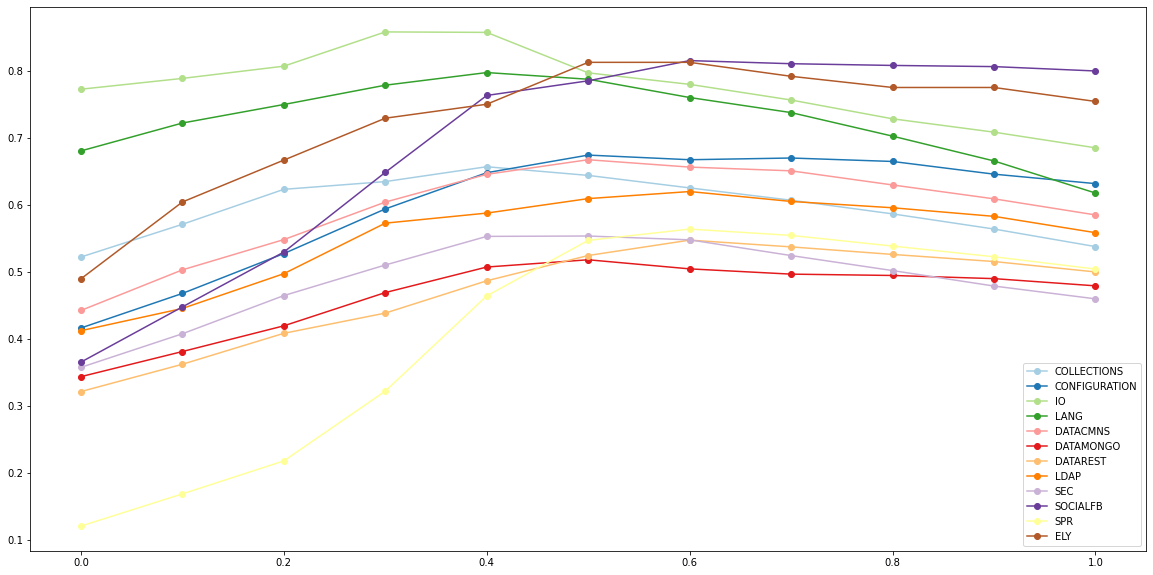

In [23]:
def alphaGraphs(df):
    plt.figure(figsize=(20,10))
    x_vals = []
    cmap = plt.get_cmap('Paired')
    for x in range(0, 11):
        x_vals.append(x/10)
    color_index = 0
    for index, row in df.iterrows():
        plt.plot(x_vals,row,label = index, marker='o', color = cmap(color_index))
        color_index +=1

    
    plt.legend()
alphaGraphs(map_scores)

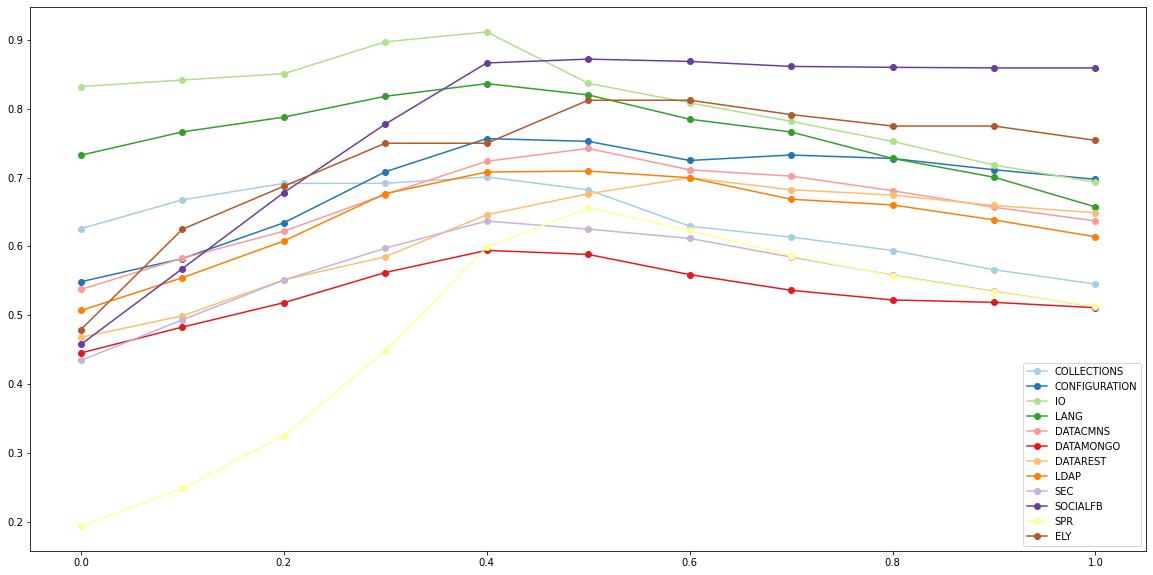

In [24]:
alphaGraphs(mrr_scores)

Best Performing MAP Scores vs Direct Comparison Only Map Scores


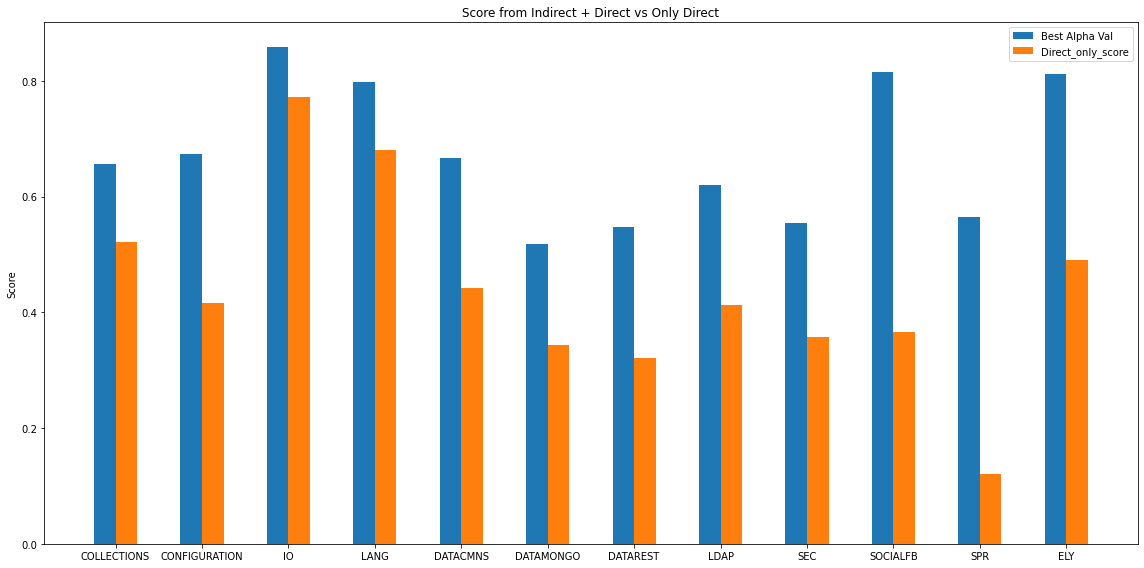

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,Best_Alpha,Best_Alpha_Val,Direct_only_score
PROJECT,,,,,,,,,,,,,,
COLLECTIONS,0.522082,0.570900,0.623074,0.634624,0.656782,0.643841,0.625202,0.606835,0.586446,0.563838,0.537657,0.4,0.656782,0.522082
CONFIGURATION,0.416245,0.467784,0.527232,0.593826,0.647860,0.674148,0.667231,0.669783,0.664644,0.645697,0.631598,0.5,0.674148,0.416245
IO,0.772412,0.788531,0.806789,0.857892,0.857186,0.796815,0.779653,0.756295,0.728267,0.708340,0.685002,0.3,0.857892,0.772412
LANG,0.680377,0.721968,0.749604,0.778395,0.797254,0.787289,0.760025,0.737535,0.702418,0.665403,0.617540,0.4,0.797254,0.680377
DATACMNS,0.442381,0.502923,0.548087,0.604040,0.645474,0.667228,0.656239,0.650652,0.629597,0.608895,0.584887,0.5,0.667228,0.442381
DATAMONGO,0.343655,0.381103,0.419444,0.469073,0.507149,0.517991,0.504431,0.496566,0.494568,0.489868,0.479119,0.5,0.517991,0.343655
DATAREST,0.321380,0.362130,0.408286,0.438472,0.486643,0.524353,0.547292,0.537217,0.525965,0.515377,0.499828,0.6,0.547292,0.321380
LDAP,0.412213,0.445379,0.497247,0.572624,0.587633,0.609230,0.619777,0.604989,0.595574,0.582764,0.558395,0.6,0.619777,0.412213
SEC,0.357529,0.407606,0.464578,0.510194,0.552877,0.553430,0.547724,0.524282,0.501881,0.478803,0.459723,0.5,0.553430,0.357529


In [25]:
# Determine best performing alpha for each project 
def getBestPerforming(df):
    df['Best_Alpha'] = df[df.columns.difference(['Best_Alpha','Best_Alpha_Val','Direct_only_score'])].idxmax(axis=1)
    df['Best_Alpha_Val'] = df[df.columns.difference(['Best_Alpha','Best_Alpha_Val','Direct_only_score'])].max(axis=1)
    df['Direct_only_score'] = df['0.0']
    
    bars = ['Best_Alpha_Val', 'Direct_only_score']
    # projects is a list of all the projects
    
    
    width = 0.5
    x = np.arange(len(projects))
    fig, ax = plt.subplots()
    rect1 = ax.bar(x - width*1/4, df["Best_Alpha_Val"], width/2, label='Best Alpha Val')
    rect2 = ax.bar(x + width*1/4, df["Direct_only_score"], width/2, label='Direct_only_score')
    
    ax.set_ylabel("Score")
    ax.set_title('Score from Indirect + Direct vs Only Direct')
    ax.set_xticks(x)
    ax.set_xticklabels(projects)
    ax.legend()
    
#     autolabel(rect1, ax)
#     autolabel(rect2, ax)
#     autolabel(rect3, ax)
    fig.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = [16, 8]
    
    
print("Best Performing MAP Scores vs Direct Comparison Only Map Scores")
getBestPerforming(map_scores)
map_scores

Best Performing MRR Scores vs Direct Comparison Only MRR Scores


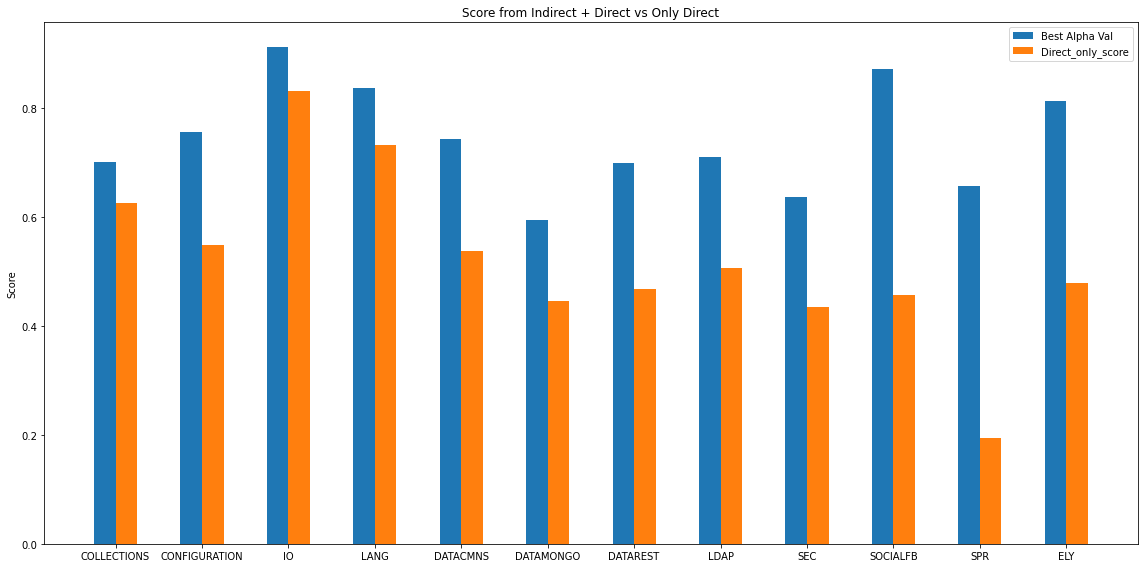

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,Best_Alpha,Best_Alpha_Val,Direct_only_score
PROJECT,,,,,,,,,,,,,,
COLLECTIONS,0.625878,0.667710,0.691579,0.691723,0.700974,0.682236,0.629366,0.613628,0.594069,0.566101,0.545312,0.4,0.700974,0.625878
CONFIGURATION,0.548639,0.582310,0.634343,0.708490,0.756663,0.752720,0.724927,0.732864,0.727792,0.711449,0.697561,0.4,0.756663,0.548639
IO,0.832333,0.841868,0.851083,0.897331,0.911793,0.837139,0.808712,0.781771,0.752641,0.718342,0.693308,0.4,0.911793,0.832333
LANG,0.732629,0.766458,0.787932,0.818214,0.836631,0.820243,0.784900,0.766323,0.727856,0.700580,0.657492,0.4,0.836631,0.732629
DATACMNS,0.537521,0.582892,0.622042,0.675381,0.723833,0.742390,0.711332,0.702138,0.681004,0.656951,0.637042,0.5,0.742390,0.537521
DATAMONGO,0.445155,0.482767,0.518203,0.562071,0.594266,0.588364,0.559028,0.536268,0.522188,0.518713,0.510910,0.4,0.594266,0.445155
DATAREST,0.467844,0.499050,0.551447,0.584964,0.646117,0.676501,0.699803,0.682355,0.674691,0.659486,0.648981,0.6,0.699803,0.467844
LDAP,0.506891,0.554537,0.607950,0.676779,0.708168,0.709540,0.699820,0.668565,0.660292,0.638528,0.613980,0.5,0.709540,0.506891
SEC,0.434359,0.493354,0.551092,0.597430,0.637004,0.625151,0.611695,0.584572,0.558285,0.534703,0.512212,0.4,0.637004,0.434359


In [26]:
print("Best Performing MRR Scores vs Direct Comparison Only MRR Scores")
getBestPerforming(mrr_scores)
mrr_scores

In [58]:
def getFixRanks(df_with_alpha,df_with_ranked_lists):
    groups = df_with_ranked_lists.groupby(df_with_ranked_lists.project)
    data = []
    for proj in projects:
        # create dataframes for each project
        bug_df = groups.get_group(proj).copy()
        
        # Get rankedList when only using the direct function (alpha = 0)
        fix_ranks_direct = get_fix_rank(bug_df['fix_indexes'],
                                                      bug_df['0.0_ranked'])
        
        # Find Which alpha performed best for this project
        alpha = df_with_alpha.loc[proj]['Best_Alpha']
        
        fix_ranks_best = get_fix_rank(bug_df['fix_indexes'],
                                                      bug_df[alpha +'_ranked'])
        print(proj)
        df_proj = pd.DataFrame()
        df_proj['fix_ranks_best'] = fix_ranks_best
        df_proj['fix_ranks_direct'] = fix_ranks_direct
        df_proj['PROJECT'] = str(proj)
#         df_proj['best_alpha'] = alpha
        data.append(df_proj)
        
    df = pd.concat(data)
    return df
# print(map_scores.loc['COLLECTIONS'])
best_ap_fix_ranks = getFixRanks(map_scores,rr_ap_scores)
best_ap_fix_ranks

COLLECTIONS
CONFIGURATION
IO
LANG
DATACMNS
DATAMONGO
DATAREST
LDAP
SEC
SOCIALFB
SPR
ELY


,fix_ranks_best,fix_ranks_direct,PROJECT
0,"[1, 4]","[1, 26]",COLLECTIONS
1,"[1, 6]","[2, 19]",COLLECTIONS
2,"[1, 2, 3]","[1, 5, 6]",COLLECTIONS
3,"[3, 4]","[2, 16]",COLLECTIONS
4,[2],[1],COLLECTIONS
...,...,...,...
3,[2],[1],ELY
4,[],[],ELY
5,[1],[3],ELY
6,[1],[1],ELY


### Fixes found in top 1%, 5% and 10% for Direct similarity only vs Combined Model

In [60]:

def GetBugsInTopN(fix_ranks):
    data = []
    groups = fix_ranks.groupby(fix_ranks.PROJECT)
#     print(groups.groups)
    for proj in projects:
        fix_df = groups.get_group(proj).copy()
        perf_list = list()
#         print("proj: ",proj)
#         print("len of fix_df: ",len(fix_df))
        
        # Fixes in top 1 for only direct 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=1 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=1 for i in x)))])/(len(fix_df)))
        # Fixes in top 1 for combined model 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=1 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=1 for i in x)))])/(len(fix_df)))
        
        
        # Fixes in top 5 for only direct 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=5 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=5 for i in x)))])/(len(fix_df)))
        # Fixes in top 5 for combined model 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=5 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=5 for i in x)))])/(len(fix_df)))

        # Fixes in top 10 for only direct 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=10 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_direct'].apply(lambda x:any(i<=10 for i in x)))])/(len(fix_df)))
        # Fixes in top 10 for combined model 
        perf_list.append(len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=10 for i in x)))]))
        perf_list.append(100 * len(fix_df[(fix_df['fix_ranks_best'].apply(lambda x:any(i<=10 for i in x)))])/(len(fix_df)))
        
        perf_list.append(len(fix_df))   
        

        data.append(perf_list)
     
    df = pd.DataFrame(data,columns=['top_1_count_direct','top_1_percent_direct','top_1_count_combined','top_1_percent_combined',
                                   'top_5_count_direct','top_5_percent_direct','top_5_count_combined','top_5_percent_combined',
                                   'top_10_count_direct','top_10_percent_direct','top_10_count_combined','top_10_percent_combined',
                                   'total_bug_count'])

    df['PROJECT'] = projects
    
    df = df.set_index(['PROJECT'])
    
    return df

bugs_in_top_N_by_best_ap_df = GetBugsInTopN(best_ap_fix_ranks)
bugs_in_top_N_by_best_ap_df

,top_1_count_direct,top_1_percent_direct,top_1_count_combined,top_1_percent_combined,top_5_count_direct,top_5_percent_direct,top_5_count_combined,top_5_percent_combined,top_10_count_direct,top_10_percent_direct,top_10_count_combined,top_10_percent_combined,total_bug_count
PROJECT,,,,,,,,,,,,,
COLLECTIONS,41,48.235294,48,56.470588,69,81.176471,75,88.235294,72,84.705882,77,90.588235,85
CONFIGURATION,52,40.000000,84,64.615385,94,72.307692,118,90.769231,109,83.846154,126,96.923077,130
IO,47,73.437500,53,82.812500,62,96.875000,63,98.437500,62,96.875000,63,98.437500,64
LANG,125,59.241706,158,74.881517,191,90.521327,201,95.260664,201,95.260664,207,98.104265,211
DATACMNS,58,39.726027,95,65.068493,103,70.547945,125,85.616438,112,76.712329,131,89.726027,146
DATAMONGO,74,31.092437,97,40.756303,142,59.663866,190,79.831933,173,72.689076,217,91.176471,238
DATAREST,43,34.400000,72,57.600000,75,60.000000,105,84.000000,86,68.800000,114,91.200000,125
LDAP,20,37.735849,31,58.490566,36,67.924528,44,83.018868,40,75.471698,50,94.339623,53
SEC,147,30.688935,236,49.269311,275,57.411273,379,79.123173,323,67.432150,412,86.012526,479


### Fixes found in top 1%, 5% and 10% for Direct similarity only vs Combined Model (Bar Chart)

In [67]:

%matplotlib inline

def generate_bar_chart(df):
    
    bars = ["% in Top 1 (Direct)", "% in Top 5", "% in Top 10"]
    # projects is a list of all the projects
    
    
    width = 0.5
    x = np.arange(len(projects))
    fig, ax = plt.subplots()
    rect4 = ax.bar(x - width*1/3, df["top_1_percent_combined"], width/3, label='% in Top 1 (Combined)',alpha=0.5)
    rect5 = ax.bar(x , df["top_5_percent_combined"], width/3, label='% in Top 5 (Combined)',alpha=0.5)
    rect6 = ax.bar(x + width*1/3, df["top_5_percent_combined"], width/3, label='% in Top 10 (Combined)',alpha=0.5)
    
    rect1 = ax.bar(x - width*1/3, df["top_1_percent_direct"], width/3, label='% in Top 1 (Direct)')
    rect2 = ax.bar(x , df["top_5_percent_direct"], width/3, label='% in Top 5 (Direct)')
    rect3 = ax.bar(x + width*1/3, df["top_10_percent_direct"], width/3, label='% in Top 10 (Direct)')
    
    ax.set_ylabel("Percentage (%)")
    ax.set_title('% Groups by Project')
    ax.set_xticks(x)
    ax.set_xticklabels(projects)
    ax.legend()
    
#     autolabel(rect1, ax)
#     autolabel(rect2, ax)
#     autolabel(rect3, ax)
    fig.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 800

generate_bar_chart(bugs_in_top_N_by_best_ap_df)
